In [1]:
import os
import math

import matplotlib
import numpy as np
import sys
import scipy
import yaml

from sklearn.metrics import mean_squared_error

sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from matplotlib import cm

from slow_reservoir.model import RNN
from slow_reservoir.dataset.dynamic_state import State

%matplotlib inline

In [2]:
def make_signal(N, time_length, state_list, uncertainty=0.5):
    input_signals = np.zeros([N, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    sigma_sq = 0.5
    target_list = np.zeros([N, 400])
    signal_mu_list = np.zeros((N, time_length))
    true_signal_list = np.zeros((N, time_length))
    
    for i in range(N):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            true_signal = state_list[t // 40]()
            true_signal_list[i, t] = true_signal
            g = 2
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            signal_mu_list[i, t] = signal_mu
            
            signal_base = g * 1 * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        # signal_mu_list.append(signal_mu)
        
    return input_signals, true_signal_list, signal_mu_list

In [3]:
config_path = '../slow_reservoir/trained_model/dynamic_state/20220331_1/20220331_1.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model = RNN(
        n_in=cfg['DATALOADER']['INPUT_NEURON'],
        n_out=1,
        n_hid=cfg['MODEL']['SIZE'],
        n_reservoir=cfg['MODEL']['RESERVOIR'],
        device=device,
        alpha_fast=cfg['MODEL']['ALPHA_FAST'],
        alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
        sigma_neu=cfg['MODEL']['SIGMA_NEU'],
    ).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state/{model_name}/epoch_3000.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()



model_name:  20220331_1


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [4]:
state_list = [
    State(mu=0, sigma=0.2),
    State(mu=0.5, sigma=0.4),
    State(mu=-0.5, sigma=0.1),
]

In [5]:
sample_num = 50
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=120, 
    uncertainty=0.5,
)

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device)                                                   

reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
        
inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device)                                                                             
hidden_list, outputs, prior_list, reservoir_list = model(inputs, hidden, reservoir, 120)                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()


In [6]:
neural_dynamics_all = neural_dynamics.reshape(50*120, 200)
reservoir_dynamics_all = reservoir_dynamics.reshape(50*120, 50)

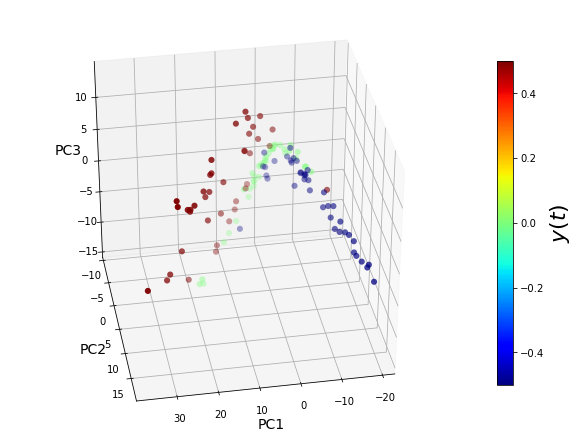

In [7]:
time_series = np.zeros(120)
time_series[:40] = 0
time_series[40:80] = 0.5
time_series[80:] = -0.5

pca = PCA(n_components=3)
pca.fit(neural_dynamics_all)

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.view_init(elev=35, azim=80)

# 軸ラベルの設定
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
ax.set_zlabel('PC3', fontsize=14)

trajectory = pca.transform(neural_dynamics[0])
    
internal_dynamics = ax.scatter(
    trajectory[:, 0], 
    trajectory[:, 1],  
    trajectory[:, 2],
    c=time_series[:],
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$y(t)$', fontsize=22)
# plt.title(r'various $\mu_{post}$ '+ f'@t={time_stamp+1}', fontsize=22)


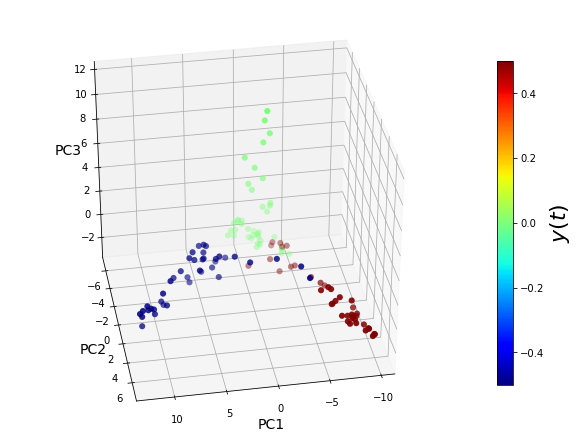

In [8]:
pca = PCA(n_components=3)
pca.fit(reservoir_dynamics_all)

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.view_init(elev=35, azim=80)

# 軸ラベルの設定
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
ax.set_zlabel('PC3', fontsize=14)

trajectory = pca.transform(reservoir_dynamics[0])
    
internal_dynamics = ax.scatter(
    trajectory[:, 0], 
    trajectory[:, 1],  
    trajectory[:, 2],
    c=time_series[:],
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$y(t)$', fontsize=22)

plt.show()


### 実験
環境Aに置いてから、0.25の入力を入れ続ける。するとどうなる？

In [9]:
import copy

initial_state_a = copy.deepcopy(neural_dynamics[0, 35])
initial_res_state_a = copy.deepcopy(reservoir_dynamics[0, 35])

initial_state_b = copy.deepcopy(neural_dynamics[0, 70])
initial_res_state_b = copy.deepcopy(reservoir_dynamics[0, 70])

initial_state_c = copy.deepcopy(neural_dynamics[0, 110])
initial_res_state_c = copy.deepcopy(reservoir_dynamics[0, 110])

In [10]:
def make_sample_signal(N, time_length, state_list, uncertainty=0.5):
    input_signals = np.zeros([N, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    sigma_sq = 0.5
    target_list = np.zeros([N, 400])
    signal_mu_list = np.zeros((N, time_length))
    true_signal_list = np.zeros((N, time_length))
    
    for i in range(N):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            true_signal = 0.25
            # true_signal_list[i, t] = true_signal
            # true_signal = state_list[2]()
            g = 2
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            signal_mu_list[i, t] = signal_mu
            
            signal_base = g * 1 * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        # signal_mu_list.append(signal_mu)
        
    return input_signals, true_signal_list, signal_mu_list

### fast, slowどちらも設定した値から始めた時

それぞれ元いた環境に応じて事前分布が異なるため、`u=0.25`の入力に対する振る舞いは異なるが、時間経過とともに出力は収束する。

- A: 事前分布の平均が`0`なのでそれに引っ張られる形で出力は0.25より小さくなる
- B: 事前分布の平均が`0.5`なのでそれに引っ張られる形で出力は0.25より大きくなる
- C: 事前分布の平均が`-0.5`なのでそれに引っ張られる形で出力は0.25より小さくなる

In [11]:
sample_num = 50
input_signal, true_signal_list, signal_mu_list = make_sample_signal(
    sample_num, 
    state_list=state_list,
    time_length=120, 
    uncertainty=0.5,
)

hidden_np = initial_state_a
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device)                                                   

reservoir_np = initial_res_state_a
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
        
inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device)                                                                             
hidden_list, outputs_a, prior_list, reservoir_list = model(inputs, hidden, reservoir, 120)                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()


hidden_np = initial_state_b
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device)                                                   

reservoir_np = initial_res_state_b
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)

hidden_list, outputs_b, prior_list, reservoir_list = model(inputs, hidden, reservoir, 120)                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()

hidden_np = initial_state_c
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device)                                                   

reservoir_np = initial_res_state_c
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)

hidden_list, outputs_c, prior_list, reservoir_list = model(inputs, hidden, reservoir, 120)                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()



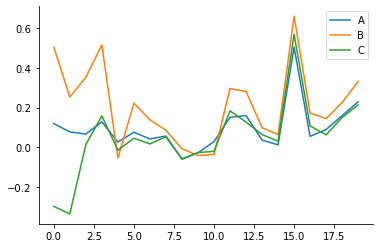

In [12]:
plt.plot(outputs_a[0, :20, 0].tolist(), label='A')
plt.plot(outputs_b[0, :20, 0].tolist(), label='B')
plt.plot(outputs_c[0, :20, 0].tolist(), label='C')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.legend()

plt.show()

### slow側がランダムな場合 

In [13]:
sample_num = 50
input_signal, true_signal_list, signal_mu_list = make_sample_signal(
    sample_num, 
    state_list=state_list,
    time_length=120, 
    uncertainty=0.5,
)

hidden_np = initial_state_a
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device)                                                   

reservoir_np = reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
        
inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device)                                                                             
hidden_list, outputs_a, prior_list, reservoir_list = model(inputs, hidden, reservoir, 120)                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()


hidden_np = initial_state_b
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device)                                                   

# reservoir_np = initial_res_state_b
# reservoir = torch.from_numpy(reservoir_np).float()
# reservoir = reservoir.to(device)

hidden_list, outputs_b, prior_list, reservoir_list = model(inputs, hidden, reservoir, 120)                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()

hidden_np = initial_state_c
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device)                                                   

# reservoir_np = initial_res_state_c
# reservoir = torch.from_numpy(reservoir_np).float()
# reservoir = reservoir.to(device)

hidden_list, outputs_c, prior_list, reservoir_list = model(inputs, hidden, reservoir, 120)                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()



slow側がランダムな場合、fast側には事前分布の情報はあまり残っていないため事前分布が出力に反映されない(時間経過とともに、正しい値へと収束していく)

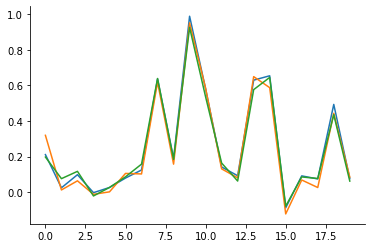

In [14]:
plt.plot(outputs_a[0, :20, 0].tolist(), label='output')
plt.plot(outputs_b[0, :20, 0].tolist(), label='output')
plt.plot(outputs_c[0, :20, 0].tolist(), label='output')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.show()

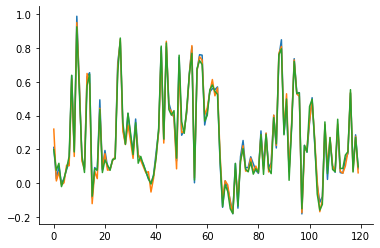

In [15]:
plt.plot(outputs_a[0, :120, 0].tolist(), label='output')
plt.plot(outputs_b[0, :120, 0].tolist(), label='output')
plt.plot(outputs_c[0, :120, 0].tolist(), label='output')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.show()

### fast側がランダムな場合

In [16]:
sample_num = 50
input_signal, true_signal_list, signal_mu_list = make_sample_signal(
    sample_num, 
    state_list=state_list,
    time_length=120, 
    uncertainty=0.5,
)

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device)                                                   

reservoir_np = initial_res_state_a
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
        
inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device)                                                                             
hidden_list, outputs_a, prior_list, reservoir_list = model(inputs, hidden, reservoir, 120)                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()


# hidden_np = initial_state_b
# hidden = torch.from_numpy(hidden_np).float()                               
# hidden = hidden.to(device)                                                   

reservoir_np = initial_res_state_b
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)

hidden_list, outputs_b, prior_list, reservoir_list = model(inputs, hidden, reservoir, 120)                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()

# hidden_np = initial_state_c
# hidden = torch.from_numpy(hidden_np).float()                               
# hidden = hidden.to(device)                                                   

reservoir_np = initial_res_state_c
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)

hidden_list, outputs_c, prior_list, reservoir_list = model(inputs, hidden, reservoir, 120)                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()



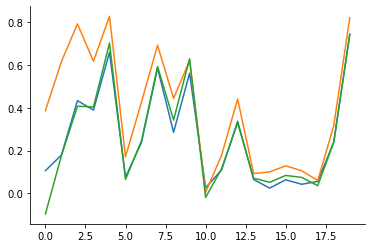

In [17]:
plt.plot(outputs_a[0, :20, 0].tolist(), label='output')
plt.plot(outputs_b[0, :20, 0].tolist(), label='output')
plt.plot(outputs_c[0, :20, 0].tolist(), label='output')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.show()

→slowに依存して、出力が決まっているという描像は成り立つ。